# Box-Jenkins法とその周辺

## 概要
### 時系列データを効率的に分析するためのフレームワーク

1. データを分析しやすくなるように変換する
  - 分析しやすい定常過程の特徴を学ぶ
  - データを定常過程に変換する方法を学ぶ
2. データにARIMAモデルやそれに準ずるモデルを適用する
  - ARIMAモデルやその発展形の仕組を学ぶ
  - モデルの同定の手順を学ぶ
3. 推定されたモデルを評価する
  - モデルの適合性の評価の方法を学ぶ
4. 推定されたモデルを用いて予測する
  - モデルの予測精度の評価の方法を学ぶ
  
#### メリット
- 分析のための手順・ルールが整備されており，自動化しやすい

#### デメリット
- ルールに縛られた分析となり，自由な分析はしにくい
- ASRIMAモデルの解釈がやや困難

わりと古典的な手法

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> https://logics-of-blue.com/python-time-series-analysis/

---
1部の内容も踏まえて軽くおさらい

In [2]:
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


[1.         0.94804734 0.87557484 0.80668116 0.75262542 0.71376997
 0.6817336  0.66290439 0.65561048 0.67094833 0.70271992]


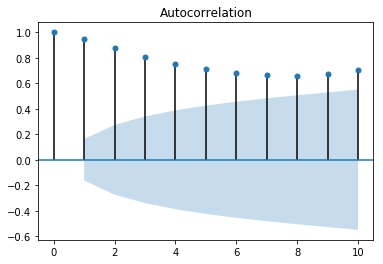

In [3]:
# 自己相関を求める
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html
# http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
ts_acf = sm.tsa.stattools.acf(df["#Passengers"],nlags=10)
print(ts_acf)
sm.graphics.tsa.plot_acf(df["#Passengers"], lags=10)
plt.show()
# 定常であるという仮定のもと，計算を行なっている？
# tのパラメータに依存しない計算になっている？

In [4]:
def acf(x: np.ndarray, nlags: int):
    """自己相関の導出"""
    rk = np.empty(nlags + 1)
    x_mean = x.mean()
    
    def _gamma(k: int):
        """自己共分散"""
        if k == 0:
            return np.sum((x - x_mean)**2)
        return np.sum((x[k:] - x_mean) * (x[:-k] - x_mean))
    
    rk[0] = _gamma(0) / _gamma(0)
    for k in range(1, nlags + 1):
        rk[k] = _gamma(k) / _gamma(0)
    return rk
acf(df["#Passengers"].values, nlags=10)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992])

In [5]:
test = df["#Passengers"].values[:10]
print(test, test.mean())
print(test[3:])
print(test[:-3])

print(test[3:] - test.mean())
print(test[:-3] - test.mean())
print((test[3:] - test.mean()) * (test[:-3] - test.mean()))

[112 118 132 129 121 135 148 148 136 119] 129.8
[129 121 135 148 148 136 119]
[112 118 132 129 121 135 148]
[ -0.8  -8.8   5.2  18.2  18.2   6.2 -10.8]
[-17.8 -11.8   2.2  -0.8  -8.8   5.2  18.2]
[  14.24  103.84   11.44  -14.56 -160.16   32.24 -196.56]


``sm.tsa.stattools.acf``では、上記の計算がなされる
- ある地点におけるラグではなく、与えられたデータセットすべての時点に対してk点のラグを計算している
- 本では、<br>$\rho_{kt}=Corr(y_t-y_{t-k})=\frac{Cov(y_t,y_{t-k})}{\sqrt{Var(y_t)Var(y_{t-k})}}$<br>とされていたが、これはtのパラメータに依存する式であり、上記のライブラリではこのtによる依存関係をなくした<br>$\rho_k=\frac{\sum_{t=k+0}^{n}(y_t-\mu)(y_{t-k}-\mu)}{\sum_{t=1}^{n}(y_t-\mu)^2}$<br>が実装されている
- **つまり、これは定常過程であるという前提での計算であることに注意**

[ 1.          0.95467704 -0.26527732  0.05546955  0.10885622  0.08112579
  0.00412541  0.15616955  0.10370833  0.28878144  0.20691805]


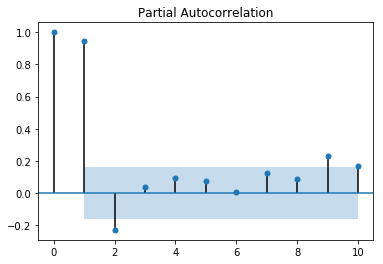

In [6]:
# 偏自己相関を求める
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.pacf.html
ts_acf = sm.tsa.stattools.pacf(df["#Passengers"],nlags=10)
print(ts_acf)
sm.graphics.tsa.plot_pacf(df["#Passengers"], lags=10)
plt.show()
# k時点前の推定量の計算方法は？
# http://www.ic.daito.ac.jp/~tkadoda/2003/computer/computerA0401.pdf

In [7]:
def _pacf(x: np.ndarray, nlag: int):
    if nlag == 0:
        return 1
    rk = np.empty(nlag + 1)
    x_mean = x.mean()
 
    gamma_matrix = np.empty([nlag, nlag])
    acfs = sm.tsa.stattools.acf(x, nlag)
    for k in range(0, nlag):
        gamma_matrix[k] = [acfs[abs(i)] for i in range(-k, nlag-k)]
    gamma_x = sm.tsa.stattools.acf(x, nlag)[1:nlag + 1]
    return np.linalg.solve(gamma_matrix, gamma_x)[-1]
print([_pacf(df["#Passengers"].values, i) for i in range(10)])

[1, 0.9546770424360754, -0.2652773166601181, 0.05546954724837748, 0.10885621529097625, 0.0811257852549132, 0.004125405440934026, 0.15616955255590315, 0.10370832997218692, 0.2887814388340048]


- こちらも、定常状態と仮定すれば期待値や分散、自己共分散が$t$に依存しないため、このような計算になる
  - ``sm.tsa.stattools.acf``と同じ結果
- 定常状態でない場合、自己相関や偏自己相関は時点$t$に依存するため、扱うには注意が必要

## 定常過程とデータの変換
### 定常性
- 定常性を持つデータ系列を定常時系列と呼ぶ
- 定常過程は，任意の$t,k$に対して以下が成立する

$E(y_t) = \mu$

$Cov(y_t, y_{t-k}) = E[(y_t-\mu)(y_{t-k}-\mu)]=\gamma_k$

- 期待値は時点によらず一定
- 自己共分散(もちろん自己相関も)時点によらず，時間差のみに依存
  - $k=0$のときの共分散が分散と等しくなることから，分散の値も時点によらず一定
- **簡単に言うと，データの水準やばらつき，自己相関の関係が時点によらず一定であるデータ**
  - 2000/1/1と2000/1/2の気温の自己相関と，2010/3/4と2010/3/5の気温の自己相関の強さは同じ
  - ホワイトノイズは期待値が常に0で自己相関も常に0で一定であるため，定常過程と言える

- 「無数に存在する2000/1/1」という日の気温の特徴を，「手元にあるたった1つの2000/1/1」から推測することが時系列データ分析の考え方

- $N$時点だけデータが有る(サンプルサイズが$N$)定常時系列に関して，データの期待値や分散，自己共分散，自己相関の推定量は以下の通り(k=0のときの共分散は分散とみなせる)

標本平均：      $\hat{\mu}=\frac{1}{N}\sum_{t=1}^{N}y_t$

標本自己共分散：$\hat{\gamma}_k=\frac{1}{N}\sum_{t=1+k}^{N}(y_t-\hat{\mu})(y_{t-k}-\hat{\mu})$

標本自己相関：  $\hat{\rho_k}=\frac{\hat{\gamma_k}}{\gamma_0}$

- 単に複数時点のデータの平均値や分散をとれば，それがそのまま「特定の時点の期待値や分散の推定量」とみなせる

- 非定常なデータは，例えば右肩上がりのトレンドがあるようなデータとか
- ただし，データの変換をすると非定常なデータでも定常になることがしばしばある
  - 差分系列
    - $\Delta y_t=y_t-y_{t-1}$
  - 一度だけ差分をとったものは1階差分，差分系列に対してもう一度差分をとったものは2階差分
  - 原系列が非定常過程であり，差分系列が定常過程であるとき，その過程を単位根過程と呼ぶ
  - $d-1$階差分をとった系列が非定常過程であり，$d$階差分をとった系列が定常過程となる場合は，<br>$d$次和文過程と呼ぶ($I(d)$)

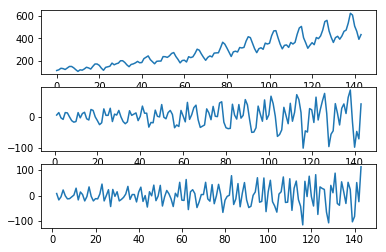

In [8]:
df["#Passengers_1d"] = df["#Passengers"] - df["#Passengers"].shift()
df["#Passengers_2d"] = df["#Passengers_1d"] - df["#Passengers_1d"].shift()
plt.subplot(311)
plt.plot(df["#Passengers"])
plt.subplot(312)
plt.plot(df["#Passengers_1d"])
plt.subplot(313)
plt.plot(df["#Passengers_2d"])
plt.show()

- 対数差分系列もよく使われる(底は$e$)
- $\Delta \log y_t=\log y_t-\log y_{t-1}$
- 対数変換をすると，足し算が掛け算に変わる
  - 時系列データ＝周期的変動＋トレンド＋ホワイトノイズ とすると<br>$\log$時系列データ＝$\log$周期的変動＋$\log$トレンド＋$\log$ホワイトノイズ<br>$\log$時系列データ＝$\log$(周期的変動\*トレンド\*ホワイトノイズ)

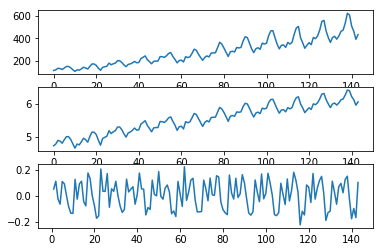

In [9]:
df["#Passengers_log"] = df["#Passengers"].apply(np.log)
df["#Passengers_log_1d"] = df["#Passengers_log"] - df["#Passengers_log"].shift()
plt.subplot(311)
plt.plot(df["#Passengers"])
plt.subplot(312)
plt.plot(df["#Passengers_log"])
plt.subplot(313)
plt.plot(df["#Passengers_log_1d"])
plt.show()

- 季節階差は，「前年同期との差」
  - 「去年の1月と今年の1月の差」みたいなやつ

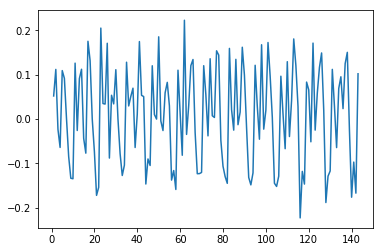

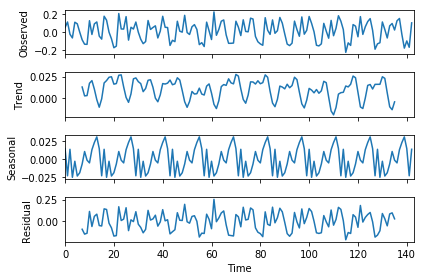

In [10]:
# 時系列データ＝短期の自己相関＋周期的変動＋トレンド＋外因性＋ホワイトノイズで表現される
# statsmodelsのseasonal_decomposeでは，時系列データ＝トレンド成分＋季節成分＋残差で表現される
# http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html?highlight=seasonal
df["#Passengers_log_1d"].dropna().plot()
res = sm.tsa.seasonal_decompose(df["#Passengers_log_1d"].dropna().values, freq=14)  # 日時データだからとりあえず7日で季節性があるか
res.plot()
plt.show()

#### ランダムウォーク

$y_t=y_{t-1}+\epsilon_t, \, \epsilon_t \sim N(0, \sigma^2)$

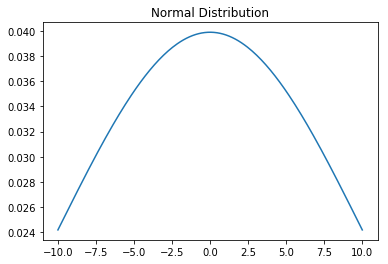

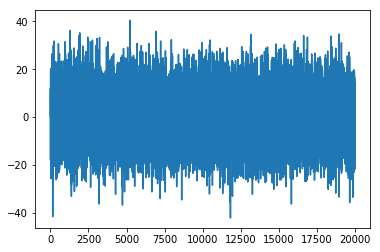

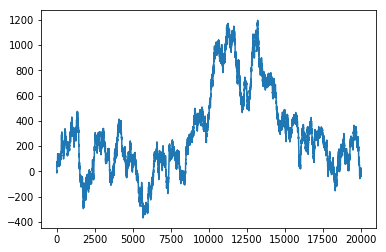

-0.0014007144557330107 9.997526181698518
np.cumsumは累積和をとることができる
np.cumsum([1,2,3,4,5] -> [ 1  3  6 10 15]


In [11]:
x = np.linspace(-10, 10, 200)
epsilon = stats.norm.pdf(x, loc=0, scale=10.0)  # locが平均，scaleが標準偏差
plt.plot(x, epsilon)
plt.title("Normal Distribution")
plt.show()
 
# サンプリングはrvsを使って取得
xs = stats.norm.rvs(loc=0, scale=10.0, size=20000)
plt.plot(xs)
plt.show()
plt.plot(np.cumsum(xs))
plt.show()
print(xs.mean(), xs.std())
print("np.cumsumは累積和をとることができる")
print(f"np.cumsum([1,2,3,4,5] -> {np.cumsum([1,2,3,4,5])}")

- 2段目，ホワイトノイズは定常過程
- 3段目，ランダムウォークは非定常過程
- ランダムウォークの1階差分がホワイトノイズで定常過程になる